In [1]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pickle
import threading
from IPython.display import clear_output

In [2]:
# exquisite acronym explanation (also sounds like lean):
# R - recurrent
# E - embedding
# A - approximation
# N - network

In [3]:
# embeddings mode
model_file = fr"./embedding_models/wiki_model3.model"
embeddings_model = Word2Vec.load(model_file)
vector_size = embeddings_model.vector_size
window = embeddings_model.window

# neural net settings
context_length = 4
input_size = context_length * vector_size + vector_size # account for previous block and current fresh inputs

# dataset
train_dataset_path = fr"./datasets/wiki_dump_train.txt"
test_dataset_path = fr"./datasets/wiki_dump_test.txt"
unique_examples_train = 4096 * 8 * 2
unique_examples_test = 4096
fluffed_up_size_train = unique_examples_train# * context_length
fluffed_up_size_test = unique_examples_test# * context_length
predicted_ram_usage = (fluffed_up_size_test + fluffed_up_size_train) * vector_size * 4 / 1000 / 1000 / 100

# training
epochs = 512
lr = 0.000003
loss = nn.MSELoss()
optimizer = torch.optim.Adam
batch_size = 512

# pytorch
run_device = torch.device("cuda")
storage_device = torch.device("cpu")

In [4]:
print("settings summary:\n")
print(f"--- embeddings model ---\nvec size: {vector_size}\nwindow: {window}\n")
print(f"--- neural network ---\ncontext length: {context_length}\nlayer input size: {input_size}\n")
print(f"--- dataset ---\nunique train examples: {unique_examples_train}\nfluffed up train size: {fluffed_up_size_train}\nunique test examples: {unique_examples_test}\nfluffed up test size: {fluffed_up_size_test}\npredicted ram requirements: {predicted_ram_usage:.2f} GB\n")
print(f"--- training ---\nepochs: {epochs}\nlr: {lr}\nbatch size: {batch_size}\noptimizer: {optimizer}\nloss: {loss}\n")
print(f"--- pytorch ---\ndevice: {run_device}   |   {torch.cuda.get_device_properties(0).name}\nVRAM capacity: {torch.cuda.get_device_properties(0).total_memory / 1024 / 1024 / 1024:.2f} GB\n")

settings summary:

--- embeddings model ---
vec size: 1024
window: 16

--- neural network ---
context length: 4
layer input size: 5120

--- dataset ---
unique train examples: 65536
fluffed up train size: 65536
unique test examples: 4096
fluffed up test size: 4096
predicted ram requirements: 2.85 GB

--- training ---
epochs: 512
lr: 3e-06
batch size: 512
optimizer: <class 'torch.optim.adam.Adam'>
loss: MSELoss()

--- pytorch ---
device: cuda   |   Tesla T4
VRAM capacity: 14.58 GB



In [5]:
# each block takes in:
# the output of the block before it (prev_block)
# the original input into the network (fresh_input)
# the original prompt of the user, not necessarily the same as original_input (<REMOVE>)
# each block returns:
# a vector of the same size as the embedding (which can be passed into the next block)
class REAN_block(nn.Module):
    def __init__(self, input_size):
        super(REAN_block, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, vector_size)

    def forward(self, prev_block: torch.Tensor, fresh_input: torch.Tensor) -> torch.Tensor:
        x = torch.cat((prev_block, fresh_input), dim=1)
        
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [6]:
class REAN(nn.Module):
    def __init__(self, input_size):
        super(REAN, self).__init__()
        
        self.block1 = REAN_block(input_size)
        self.block2 = REAN_block(input_size)
        self.block3 = REAN_block(input_size)
        self.block4 = REAN_block(input_size)
        self.block5 = REAN_block(input_size)
        self.block6 = REAN_block(input_size)
        self.block7 = REAN_block(input_size)
        self.block8 = REAN_block(input_size)

    def forward(self, current_segment: torch.Tensor) -> torch.Tensor:
        # keep an x's clone from the start so the blocks get fresh input
        self.fresh_input = current_segment.clone()
        
        self.fresh_input = self.fresh_input.reshape(current_segment.shape[0], vector_size * context_length)
        
        # supplement the (currently non existant) previous block's output with the latest word
        current_segment = self.block1(current_segment[:, -1], self.fresh_input)
        current_segment = self.block2(current_segment, self.fresh_input)
        current_segment = self.block3(current_segment, self.fresh_input)
        current_segment = self.block4(current_segment, self.fresh_input)
        current_segment = self.block5(current_segment, self.fresh_input)
        current_segment = self.block6(current_segment, self.fresh_input)
        current_segment = self.block7(current_segment, self.fresh_input)
        current_segment = self.block8(current_segment, self.fresh_input)
        
        return current_segment

net = REAN(input_size)
net.to(run_device)
optimizer = optimizer(net.parameters(), lr=lr)

In [7]:
def vectorize_sentence(sentence: list[str], model: Word2Vec, default: int = 0) -> np.ndarray:
    """
    encodes all words in a given list to corresponding vectors in given model.
    words not found in the model will be given a vector with "default" value
    
    parameters:
        sentence (list): list of strings (words)
        model (Word2Vec): model to use when encoding
        default (int): fill vector with this value if word is not found in model
    
    returns:
        np.array: 2d array with dim1 = len(sentence) and dim2 = model.vector_size
    """
    
    # generate inital array with default values
    vectorized = np.ones((len(sentence), model.vector_size)) * default
    
    # loop over every word in list
    for current_word, current_word_idx in zip(sentence, range(len(sentence))):
        # only add correct values if word is in model, otherwise leave as default
        if current_word in model.wv:
            vectorized[current_word_idx] *= 0
            vectorized[current_word_idx] += model.wv[current_word]
    
    return vectorized

In [8]:
def devectorize_sentence(vectorized_sentence: np.array, model: Word2Vec) -> list:
    """
    decodes vectors into nearest word found in model
    
    parameters:
        vectorized_sentence (np.array): 2d arrat with vectors of words to be decoded
        model (Word2Vec): model to use when decoding
    
    returns:
        list: list of strings (words) whos vectors most closely match those provided
    """
    
    result = []
    
    # go over all words and find closest match in model
    for current_word in vectorized_sentence:
        result.append(model.wv.similar_by_vector(current_word)[0][0])
    
    return result

In [9]:
def pad_or_truncate(suspected_tensor: torch.tensor, target_length: int, default: int=0) -> torch.Tensor:
    """
    pads or truncates a given tensor along dim 0 to target_length with "default" as padding
    
    parameters:
        suspected_tensor (torch.tensor): tensor to pad or truncate
        target_length (int): target length of tensor
        default (int): value to use for padding
    
    returns:
        torch.tensor: tensor of proper length no matter what
    """
    
    if len(suspected_tensor) < target_length:
        # pad
        suspected_tensor = torch.cat((torch.ones(target_length - len(suspected_tensor), suspected_tensor.shape[1], dtype=torch.float32, device=suspected_tensor.device) * default, suspected_tensor))
    else:
        # truncate
        suspected_tensor = suspected_tensor[-target_length:]
    
    return suspected_tensor

In [10]:
def prepare_sentence_for_net(sentence: list, model: Word2Vec, context_length: int, flatten: bool=True, used_device: torch.device=run_device) -> torch.Tensor:
    """
    turns a sentence (list of strings) into a tensor that can be fed directly into the network
    
    parameters:
        sentence (list): list of strings (words)
        model (Word2Vec): model to use when encoding sentence
        context_length (int): length of context to consider when encoding, should be same as network's
    
    returns:
        torch.tensor: tensor of proper length no matter what
    """
    
    # encode sentence to np.array
    vectorized = vectorize_sentence(sentence, model)
    vectorized_tensor = torch.from_numpy(vectorized).to(used_device).to(torch.float32)
    
    # pad or truncate
    vectorized_tensor = pad_or_truncate(vectorized_tensor, context_length)
    
    if flatten:
        # flatten to fit into first fc layer of the net
        vectorized_tensor = vectorized_tensor.flatten()
    
    return vectorized_tensor

In [11]:
def predict_word(current_segment: list, net: REAN, embeddings_model: Word2Vec) -> str:
    """
    uses the net and the model to predict the next word to fit the given sentence
    
    parameters:
        sentence (list): list of strings (words)
        net (GPT_like): net to use when predicting
        model (Word2Vec): embedding model to use when encoding sentence
    
    returns:
        str: predicted word
    """
    encoded_segment = prepare_sentence_for_net(current_segment, embeddings_model, context_length, flatten=False)
    
    # run sentence
    output = net(encoded_segment.unsqueeze(0))
    
    # add the net's vector to the end of the current segment
    target = output + encoded_segment[-1]
    
    # decode most similar word to whatever net predicted
    predicted_word = embeddings_model.wv.similar_by_vector(target.detach().squeeze(0).cpu().numpy())[0][0]
    
    return predicted_word

In [12]:
def predict_sequence(sentence: list, net: REAN, embeddings_model: Word2Vec, num_completions: int) -> list:
    """
    predicts multiple words at the end of the given sentence
    
    parameters:
        sentence (list): list of strings (words)
        net (GPT_like): net to use when predicting
        model (Word2Vec): embedding model to use when encoding sentence
        num_completions (int): number of words to predict
    
    returns:
        list: list of words to be appended to given sentence
    """
    
    predicted_result = sentence
    
    for _ in tqdm(range(num_completions)):
        # give the network the full context to work with, while only collecting the predicted part into the result
        predicted_result.append(predict_word(predicted_result, net, embeddings_model))
    
    return predicted_result

In [13]:
def train_segment(current_segment: torch.Tensor, target: torch.Tensor, net: REAN, optimizer: torch.optim.Optimizer, loss: torch.nn.MSELoss, loss_graph: list):
    # move batch to gpu
    current_segment = current_segment.to(run_device)
    target = target.to(run_device)
    
    # train batch
    optimizer.zero_grad()
    
    train_outputs = net(current_segment)
    train_loss_value = loss(train_outputs, target)
    train_loss_value.backward()
    optimizer.step()
    
    # collect performance metrics
    loss_graph.append(train_loss_value.item())

In [14]:
def test_segment(test_current_segment: torch.Tensor, test_target: torch.Tensor, net: REAN, loss: torch.nn.MSELoss, loss_graph: list):
    # move batch to gpu
    test_current_segment = test_current_segment.to(run_device)
    test_target = test_target.to(run_device)
    
    test_outputs = net(test_current_segment)
    test_loss_value = loss(test_outputs, test_target)
    loss_graph.append(test_loss_value.item())

In [15]:
class REAN_dataset(Dataset):
    def load_dataset_chunk(self, path: str, num_words: int, seek_start: int, sep: str = " ") -> tuple[list, bool, int]:
        """
        function to load a chunk of the dataset where the words are separated by "sep" into a list
        
        parameters:
            path (str): path to the dataset txt file
            num_words (int): number of words to load
            seek_start (int): start char to pull words from
            sep (str, optional): separator in the dataset, defaults to space " "
        
        returns:
            list: list of strings (loaded words), is EOF hit, seek position to move 1 word forward
        """
        
        # some safety checks so later code looks cleaner
        self.num_words = max(0, num_words)
        self.seek_start = max(0, seek_start)
        
        self.words = []
        self.current_word_idx = 0
        self.word_buffer = ""
        self.current_seek = seek_start
        self.next_seek = 0
        self.first_word_flag = True

        with open(path, 'r', encoding='utf-8', errors='ignore') as self.file:
            self.file.seek(seek_start)
            
            # loop over all chars after seek_start
            while True:
                self.char = self.file.read(1)
                self.current_seek += 1
                
                # end of file, return whatever has been collected immediately
                if not self.char:
                    return self.words, True, self.next_seek
                
                # is a separator between words hit
                if self.char == sep or self.char.isspace():
                    if self.word_buffer:
                        if self.current_word_idx < self.num_words:
                            self.words.append(self.word_buffer)
                        
                        self.current_word_idx += 1
                        self.word_buffer = ""
                    
                    if self.current_word_idx >= self.num_words:
                        break
                    
                    # the first word is covered, this is where the next chunk is going to be loaded from
                    if self.first_word_flag:
                        self.first_word_flag = False
                        self.next_seek = self.current_seek
                else:
                    self.word_buffer += self.char

        return self.words, False, self.next_seek
    
    def retrieve_example(self, path: str, seek_start: int, context_length: int, cut: int, embeddings_model: Word2Vec):
        self.current_segment, self.eof, self.seek_start = self.load_dataset_chunk(path, context_length + 1, seek_start)
        
        self.context = prepare_sentence_for_net(self.current_segment[:-1], embeddings_model, context_length, flatten=False, used_device=storage_device)
        self.target = prepare_sentence_for_net([self.current_segment[-1]], embeddings_model, 1, flatten=False, used_device=storage_device).squeeze(0)
        
        self.context = prepare_sentence_for_net(self.current_segment[:-1][cut:], embeddings_model, context_length, flatten=False, used_device=storage_device)
        
        self.diff = self.target - self.context[-1]
        
        return self.context, self.diff
    
    def initialize_example_coordinates(self, path: str, context_length: int, num_unique_examples):
        self.seek_start = 0
        self.fluffed_up_size = 0
        self.example_coords_list = []
        
        for _ in tqdm(range(num_unique_examples)):
            # we need to retrieve the real seek start of the file, thats why this function is called here
            _, self.eof, self.seek_start = self.load_dataset_chunk(path, context_length, self.seek_start)

            # append all possible options for this example
            #for self.current_cut in range(context_length):  # TMP DISABLE CUT
            self.example_coords_list.append((self.seek_start, 0))
            self.fluffed_up_size += 1
    
        return self.example_coords_list, self.fluffed_up_size, False
    
    def __init__(self, path, num_unique_examples, context_length, embeddings_model):
        self.path = path
        self.embeddings_model = embeddings_model
        self.example_coords_list, self.fluffed_up_size, self.eof_hit = self.initialize_example_coordinates(path, context_length, num_unique_examples)
        
        # in case file is too small for requested size
        if self.eof_hit:
            print("eof hit, early stop")
        
        print(f"fluffed up size: {self.fluffed_up_size}")
        
    def __len__(self):
        return self.fluffed_up_size
    
    def __getitem__(self, index):
        return self.retrieve_example(self.path, self.example_coords_list[index][0], context_length, self.example_coords_list[index][1], self.embeddings_model)

In [16]:
train_dataset = REAN_dataset(train_dataset_path, unique_examples_train, context_length, embeddings_model)
test_dataset = REAN_dataset(test_dataset_path, unique_examples_test, context_length, embeddings_model)

100%|██████████| 65536/65536 [00:01<00:00, 37250.39it/s]


fluffed up size: 65536


100%|██████████| 4096/4096 [00:00<00:00, 35924.92it/s]

fluffed up size: 4096


In [36]:
devectorize_sentence(train_dataset[401][0].detach().cpu().numpy(), embeddings_model)

['call', 'himself', 'an', 'anarchist']

In [37]:
devectorize_sentence(train_dataset[401][1].detach().unsqueeze(0).cpu().numpy(), embeddings_model)

['was']

In [17]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [18]:
train_loss_graph = []
test_loss_graph = []

In [19]:
for epoch in tqdm(range(epochs)):
    for current_segment, target in train_loader:
        train_thread = threading.Thread(target=train_segment, args=(current_segment, target, net, optimizer, loss, train_loss_graph))
        train_thread.start()
        
    if epoch % 24 == 0:
        with torch.no_grad():
            for test_current_segment, test_target in test_loader:
                testing_thread = threading.Thread(target=test_segment, args=(test_current_segment, test_target, net, loss, test_loss_graph))
                testing_thread.start()

 75%|███████▌  | 386/512 [1:59:39<39:03, 18.60s/it]  


KeyboardInterrupt: 

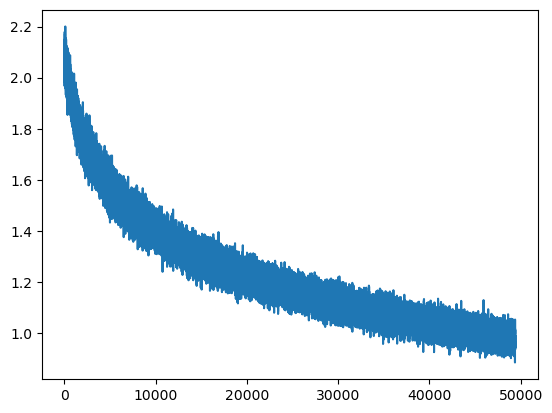

In [20]:
plt.plot(train_loss_graph)

In [ ]:
#torch.save(net.state_dict(), 'no_attention_mech.pth')

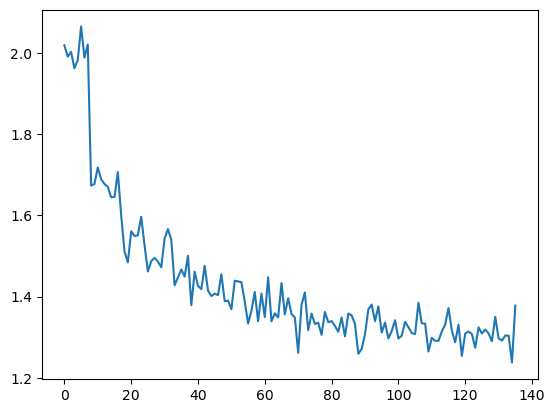

In [21]:
plt.plot(test_loss_graph)

In [38]:
sentence = "call himself an anarchist".split(" ")

In [39]:
" ".join(predict_sequence(sentence, net, embeddings_model, 32))

100%|██████████| 32/32 [00:02<00:00, 15.25it/s]


'call himself an anarchist was briley by the state and onfederate was the state legislature has been proposed proposed proposed proposed proposed proposed proposed proposed proposed proposed proposed proposed proposed proposed proposed proposed proposed proposed proposed'